# Uncertainty 

This is a tutorial for the uncertainty module.

## Uncertainty and sensitivity analysis?

Before doing an uncertainty analysis in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g. [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel2020](https://www.research-collection.ethz.ch/handle/20.500.11850/399735).

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="600">

1. [Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
2. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
3. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
4. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Uncertainty Module Structure

The uncertainty module contains 2 main classes
- `UncVar`: defines uncertainty variables
- `Uncertainty`: base class to compute uncertainties and sensitivities for CLIMADA outputs.

In addition, there are the child classes of `Uncertainty` defined in their submodules:

- `UncImpact`: specific class to compute uncertainties for outputs of `climada.engine.impact.calc`
- `UncCostBenefit`: specific class to compute uncertainties for outputs of `climada.engine.cost_benefit.calc`

### UncVar 

The UncVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| uncvar_func | funnction | Variable defined as a function of the uncertainty parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty parameters |

An **uncertainty parameter** is an input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope the vulnerability function, the exponent of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the uncertainty parameters (keyword arguments of the `uncvar_func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

#### Example - continuous uncertainty parameter

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [12]:
#Define the base exposure
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

2021-03-18 16:41:01,479 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-18 16:41:01,481 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-18 16:41:01,482 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-18 16:41:01,484 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-18 16:41:01,485 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-18 16:41:01,486 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-18 16:41:01,513 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-18 16:41:01,514 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-18 16:41:01,514 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-18 16:41:01,515 - climada.entity.exposures.base - INF

In [3]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the uncertainty parameter and exp_func the uncvar_func.
def exp_func(x_exp, exp_base=exp_base):
    exp = copy.deepcopy(exp_base)
    exp.gdf.value *= x_exp
    return exp

In [4]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the uncertainty parameter x_exp is sp.stats.uniform(0.9, 1.1)
from climada.engine.uncertainty import UncVar

exp_distr = {"x_exp": sp.stats.uniform(0.9, 1.1),
              }
exp_unc = UncVar(exp_func, exp_distr)

In [5]:
# Uncertainty parameters
exp_unc.labels

['x_exp']

In [8]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_unc.evaluate({'x_exp': 0.95})
print(f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}")

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


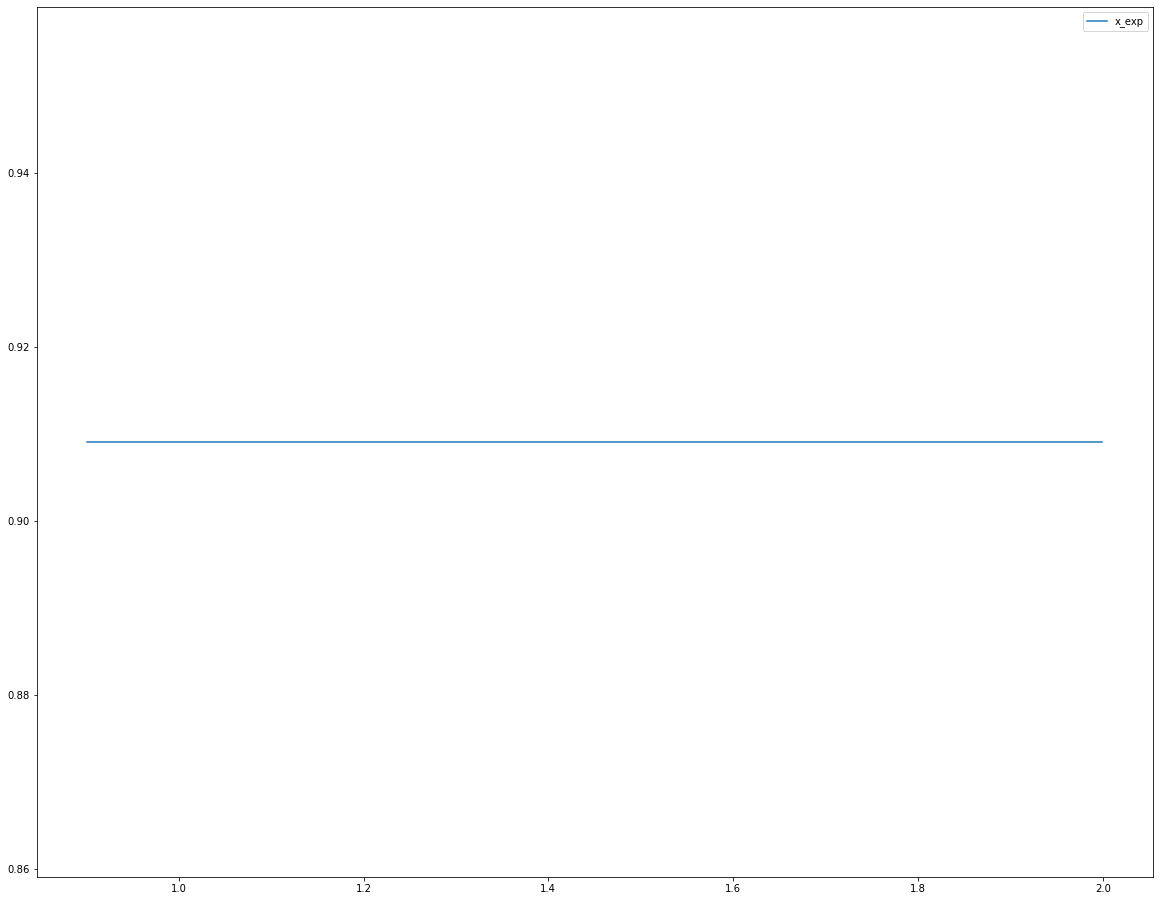

In [11]:
# Defined distribution
exp_unc.plot();

#### Example - categorical uncertainty parameter 

Suppose we want to test different exponents (m=0,1,2 ; n=0,1,2) for the LitPop exposure for the country Switzerland.

In [ ]:
from climada.entity import LitPop

m_min, m_max = (0, 2)
n_min, n_max = (0, 2)

# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow. 
def litpop_cat(m, n):
    exp = Litpop()
    exp.set_country('CHE', exponent=[m, n])
    return exp

In [30]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = exp.copy()
        exp_mn.set_country('CHE', exponent=[m, n])
        litpop_dict[(m, n)] = exp_mn
        
def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

2021-03-24 18:25:36,311 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:25:36,313 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:25:36,314 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:25:36,315 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:25:36,316 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-24 18:25:37,707 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:25:46,833 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:25:46,834 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:25:58,047 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:25:58,482 - climada.util.finance 

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:26:00,521 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:26:09,706 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:26:09,707 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:26:21,039 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:26:21,479 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:26:22,089 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:26:22,090 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:26:22,090 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:26:22,091 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:26:22,108 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:26:23,489 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:26:32,580 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:26:32,580 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:26:43,872 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:26:44,316 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:26:44,929 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:26:44,929 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:26:44,930 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:26:44,930 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:26:44,948 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:26:46,338 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:26:55,125 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:26:55,126 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:27:06,132 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:27:06,553 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:27:07,134 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:27:07,135 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:27:07,136 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:27:07,137 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:27:07,154 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:27:08,421 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:27:17,336 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:27:17,336 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:27:28,877 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:27:29,313 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:27:30,058 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:27:30,059 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:27:30,059 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:27:30,060 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:27:30,075 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:27:31,494 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:27:40,777 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:27:40,778 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:27:52,355 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:27:52,784 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:27:53,364 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:27:53,365 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:27:53,365 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:27:53,365 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:27:53,382 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:27:54,592 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:28:03,756 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:28:03,757 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:28:15,416 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:28:15,857 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:28:16,596 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:28:16,596 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:28:16,597 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:28:16,598 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:28:16,615 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:28:17,959 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:28:26,837 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:28:26,838 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:28:38,299 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:28:38,764 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:28:39,385 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:28:39,385 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:28:39,386 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:28:39,386 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:28:39,404 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-24 18:28:40,643 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-24 18:28:49,525 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-24 18:28:49,526 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-24 18:29:00,923 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-24 18:29:01,354 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-24 18:29:02,086 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:29:02,087 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:29:02,087 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:29:02,088 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:29:02,103 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


In [31]:
#Define the distribution dictionnary
distr_dict = {
    'm': sp.stats.randint(low=m_min, high=m_max),
    'n': sp.stats.randint(low=n_min, high=n_max)
    }

unc_var_cat = UncVar(litpop_cat, distr_dict) # One can use either of the above definitions of litpop_cat

In [41]:
# Uncertainty parameters
unc_var_cat.labels

['m', 'n']

###  UncImpact

#### Set the UncVars 

In [46]:
import copy
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.entity.entity_def import Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In [47]:
def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    exp.check()
    return exp

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

2021-03-24 18:40:47,930 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:40:47,931 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:40:47,932 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:40:47,933 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 18:40:47,934 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-24 18:40:47,936 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-24 18:40:47,958 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 18:40:47,959 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 18:40:47,960 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 18:40:47,961 - climada.entity.exposures.base - INF

In [48]:
exp = exp_func
exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp, exp_distr)

impf = impf_func
impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf, impf_distr)

haz = haz_base

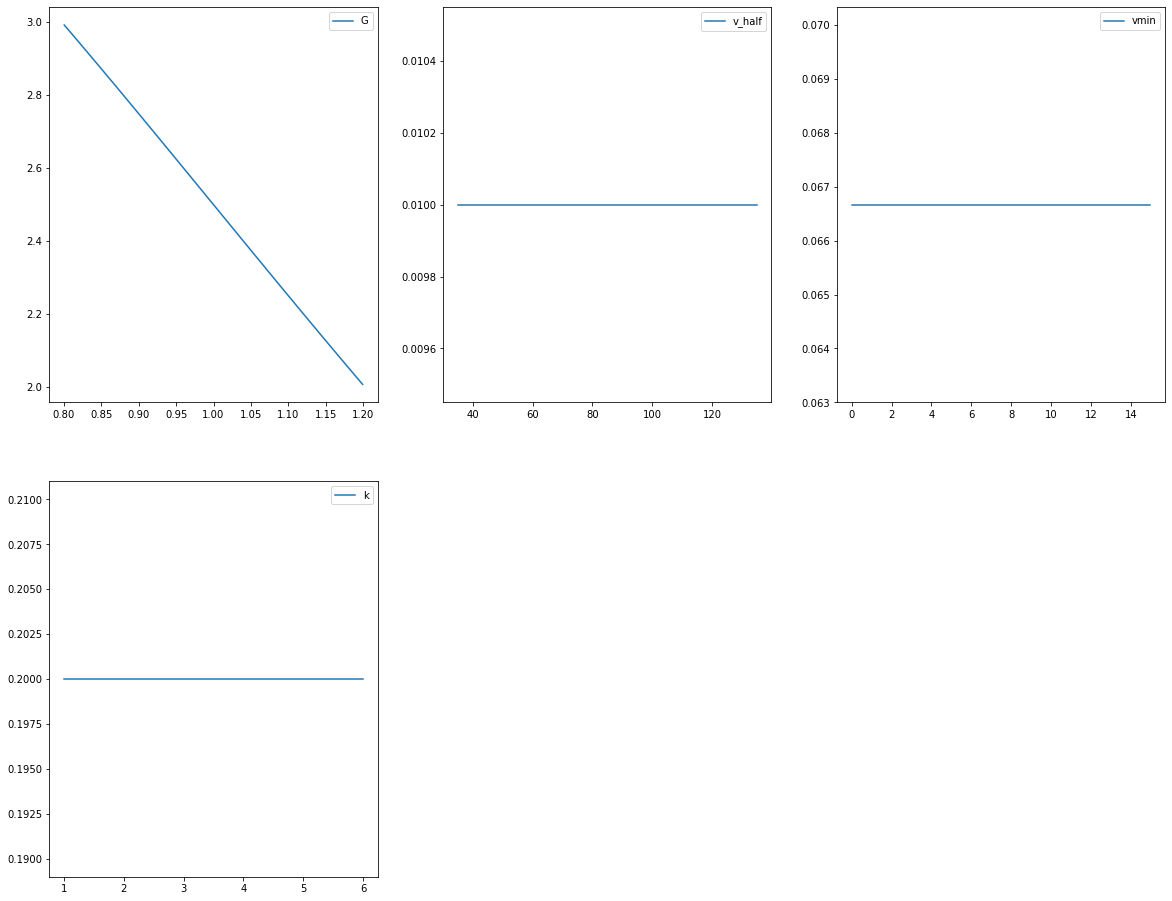

In [49]:
impf_unc.plot();

#### Compute uncertainty and sensitivity using default methods 

First, we define the UncImpact object with our uncertainty variables

In [50]:
unc = UncImpact(exp_unc, impf_unc, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [52]:
unc.make_sample(N=100)

2021-03-24 18:44:40,984 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1200


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
1195,0.600502,1.015208,41.396484,11.037598,4.239746
1196,0.600502,0.853179,91.494141,11.037598,4.239746
1197,0.600502,0.853179,41.396484,1.560059,4.239746
1198,0.600502,0.853179,41.396484,11.037598,5.855957


The resulting samples can be visualized in plots.

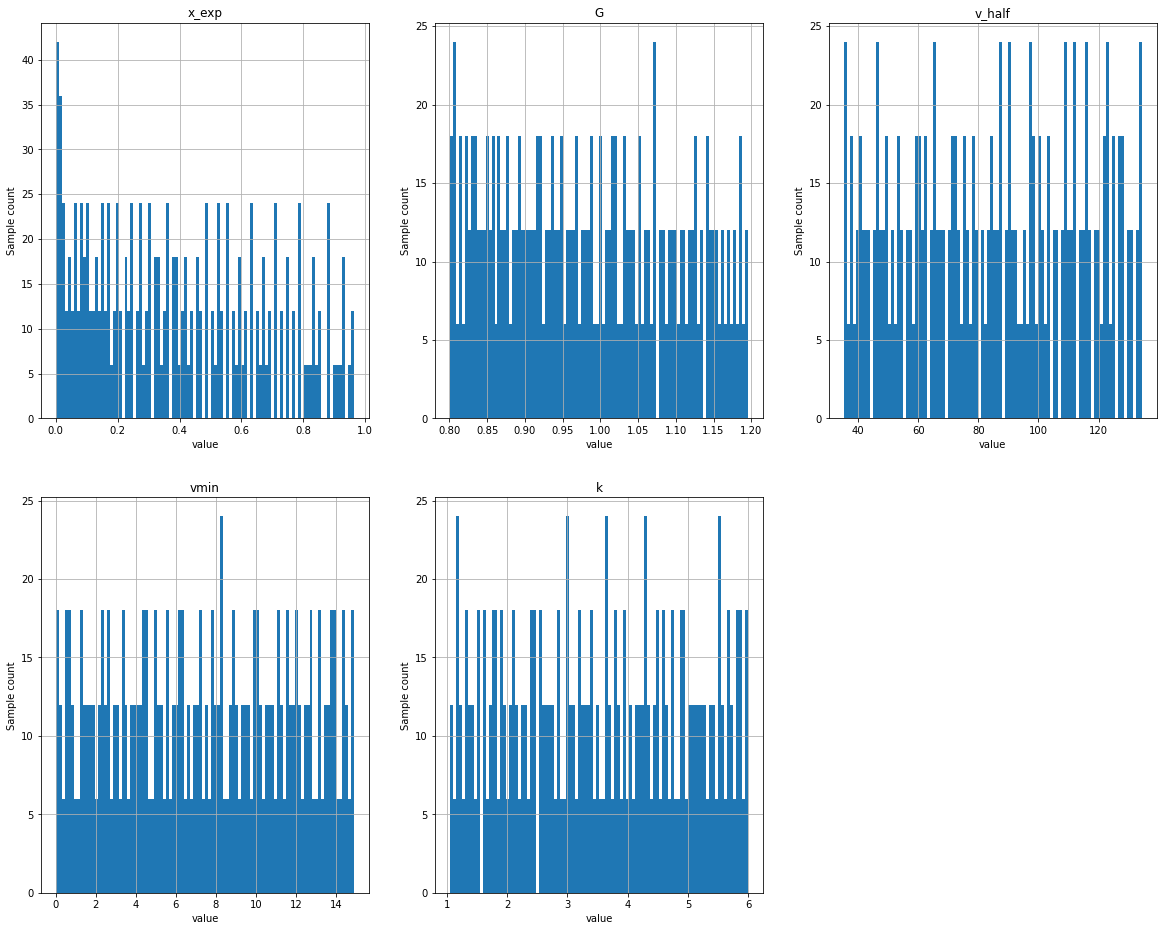

In [53]:
unc.plot_sample();

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to compute only the return periods 50, 100, and 250 years

In [60]:
unc.calc_distribution(rp = [50, 100, 250])

2021-03-24 18:49:29,465 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-24 18:49:29,466 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-24 18:49:29,468 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-24 18:49:29,474 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-24 18:49:29,479 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 21.240000000000002s



The distributions of metrics ouputs are stored as dictionary and follow the same style as the output of `climada.impact.calc`.

In [61]:
unc.metrics

{'aai_agg':            aai_agg
 0     1.452259e+08
 1     9.638108e+08
 2     1.422086e+08
 3     5.798529e+07
 4     1.699837e+08
 ...            ...
 1195  3.466737e+09
 1196  8.223227e+07
 1197  3.519707e+09
 1198  2.475507e+09
 1199  2.913440e+09
 
 [1200 rows x 1 columns],
 'freq_curve':               rp50         rp100         rp250
 0     4.190439e+09  5.459388e+09  6.716189e+09
 1     2.781041e+10  3.623196e+10  4.457288e+10
 2     4.103377e+09  5.345963e+09  6.576651e+09
 3     1.668605e+09  2.195785e+09  2.728832e+09
 4     4.852968e+09  6.169638e+09  7.454678e+09
 ...            ...           ...           ...
 1195  1.027197e+11  1.440714e+11  1.832228e+11
 1196  2.242984e+09  3.585708e+09  5.083031e+09
 1197  1.027906e+11  1.314927e+11  1.574598e+11
 1198  7.067343e+10  1.096797e+11  1.503698e+11
 1199  8.632543e+10  1.210773e+11  1.539801e+11
 
 [1200 rows x 3 columns],
 'eai_exp': Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

The distributions of the metrics can be vizualised with plots.

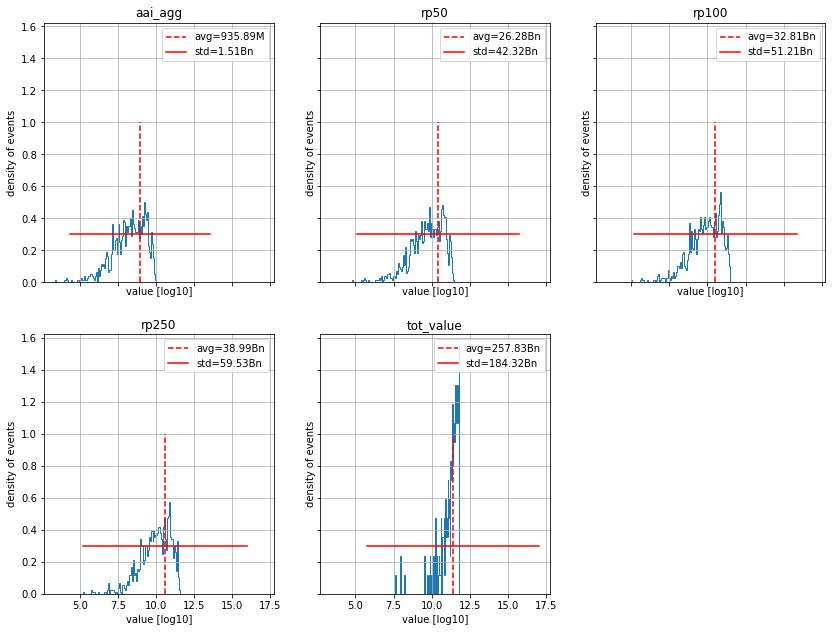

In [63]:
unc.plot_distribution();

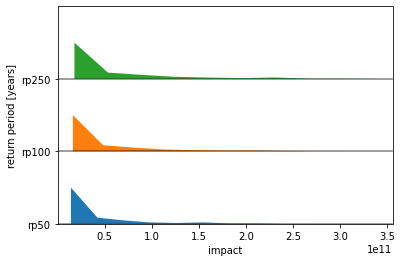

In [64]:
unc.plot_rp_distribution();

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

In [65]:
unc.calc_sensitivity()

2021-03-24 18:52:01,786 - climada.engine.uncertainty.base - WARNING - The chosen combination of sensitivity method (None) and sampling method (sobol) does not correspond to the recommendation of the salib pacakge.
 https://salib.readthedocs.io/en/latest/api.html


{'aai_agg': {'aai_agg': {'S1': array([0.35319533, 0.02894084, 0.29014581, 0.00245273, 0.07358847]),
   'S1_conf': array([0.17560692, 0.03549152, 0.20321004, 0.02508234, 0.1159415 ]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.19185046, 0.01587417, 0.30640542, 0.00853757, 0.1521457 ]),
   'S2': array([[        nan, -0.24100036, -0.0349894 , -0.24132635, -0.169576  ],
          [        nan,         nan, -0.05162803, -0.04726681, -0.04375917],
          [        nan,         nan,         nan, -0.02073784,  0.00665134],
          [        nan,         nan,         nan,         nan, -0.00056325],
          [        nan,         nan,         nan,         nan,         nan]]),
   'S2_conf': array([[       nan, 0.25920384, 0.3988857 , 0.25610178, 0.23799165],
          [       nan,        nan, 0.07672052, 0.06848412, 0.04736371],
          [       nan,        nan,        nan, 0.25599699, 0.3037863 ],
          [       nan,        nan,  

The value of the sensitivity indices can be plotted for each metric

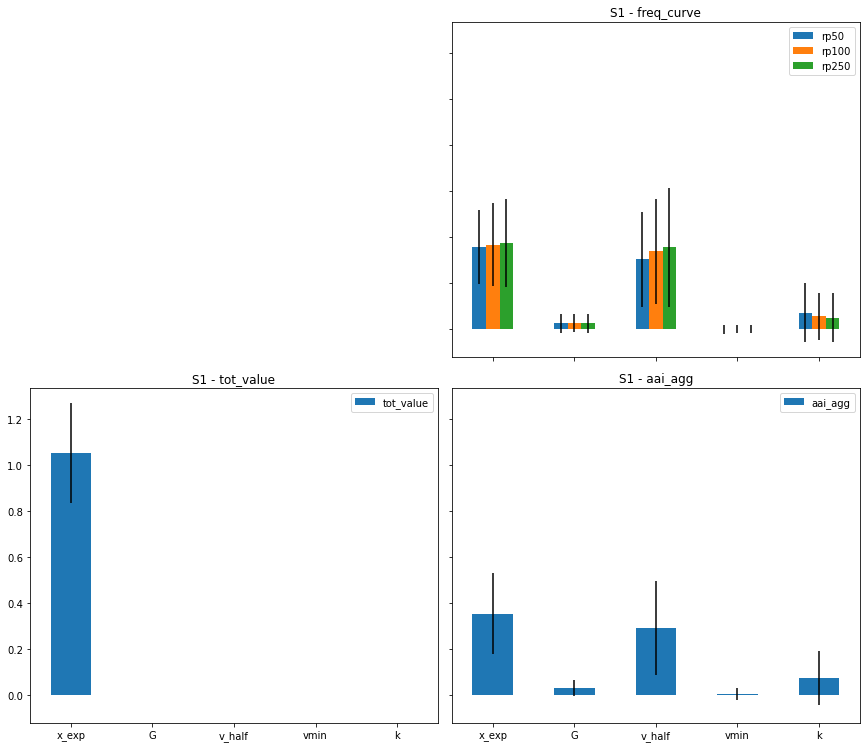

In [66]:
unc.plot_sensitivity();

In addition, a map showing the largest sensitivity index in each exposure location can be shown.

### Different Salib method 

In [49]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='latin')

2021-03-05 16:15:30,747 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 100


,x_exp,G,v_half,vmin,k
0,0.834941,0.846536,86.335688,11.114022,3.456025
1,0.318263,0.887897,38.348157,2.899003,1.843364
2,0.281322,0.824986,51.343855,5.838540,3.561908
3,0.004032,1.158169,126.212002,9.041936,2.608376
4,0.141698,0.869180,73.184722,9.778151,4.575570
...,...,...,...,...,...
95,0.895257,0.912970,120.120380,0.407957,3.934892
96,0.838480,1.045294,41.099363,4.384443,2.092723
97,0.801707,1.085927,133.989928,3.904060,1.004676
98,0.760685,0.958645,115.847732,11.680385,1.897609


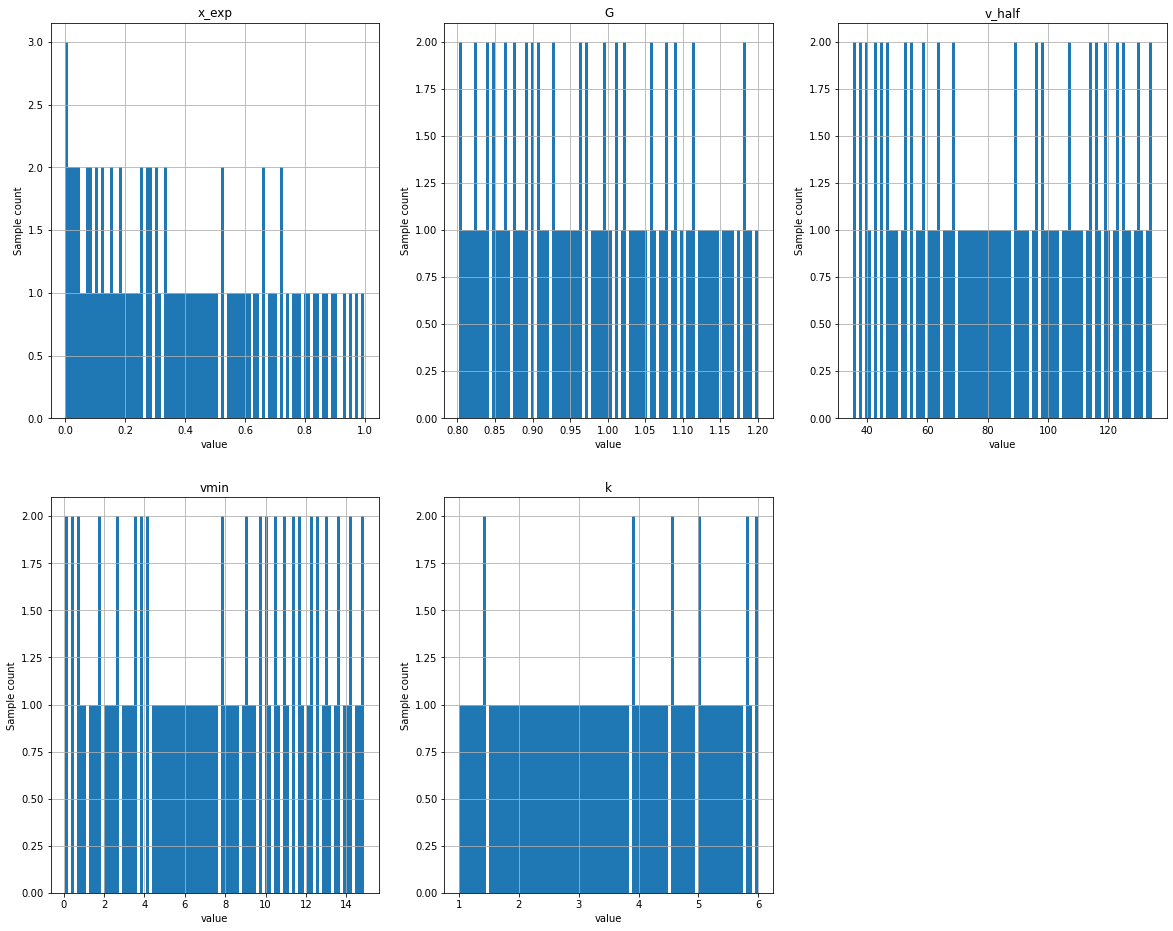

In [50]:
unc.plot_sample();

In [51]:
unc.calc_distribution(rp = [50, 100, 250], )

2021-03-05 16:15:32,118 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-05 16:15:32,120 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-05 16:15:32,122 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-05 16:15:32,129 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-05 16:15:32,135 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 2.08s



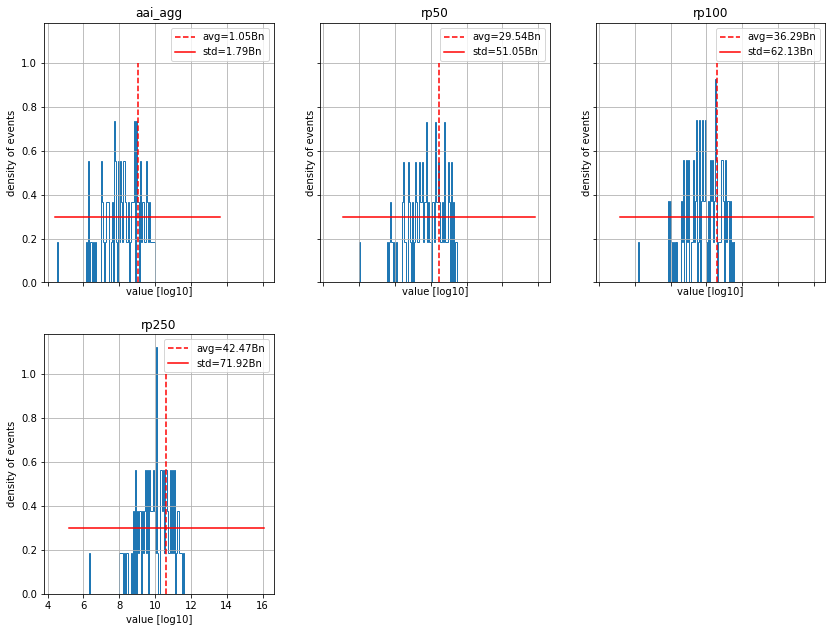

In [52]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

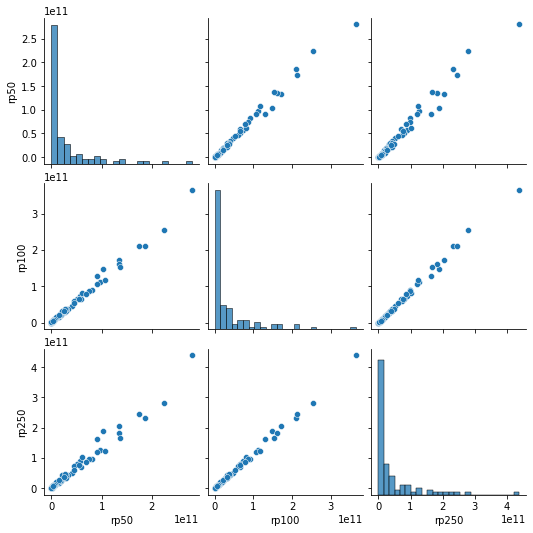

In [53]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);

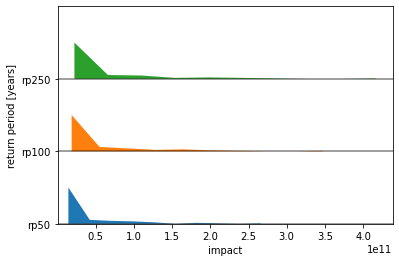

In [54]:
unc.plot_rp_distribution();

In [55]:
unc.calc_sensitivity(salib_method='rbd_fast', method_kwargs = {'M': 15})

{'aai_agg': {'aai_agg': {'S1': [0.04644177434287955,
    -0.1039276905290655,
    0.5106917086606744,
    -0.16897249528680358,
    0.07259397303765386],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'freq_curve': {'rp50': {'S1': [0.047961950333668846,
    -0.10722709552072454,
    0.5315246177874814,
    -0.1701065467053979,
    0.0522395304203942],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp100': {'S1': [0.04913790657082773,
    -0.11390412099929204,
    0.567913925982113,
    -0.1695845484724345,
    0.02534011060394259],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp250': {'S1': [0.05222964699193855,
    -0.11777479185776027,
    0.5867941711167849,
    -0.16811800686824063,
    0.010184768711696768],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'eai_exp': {},
 'at_event': {},
 'tot_value': {'tot_value': {'S1': [0.999718910871201,
    -0.09346530032190975,
    0.11561485691458612,
    -0.11931481657529616,
    0.05343487188185225],
   'name

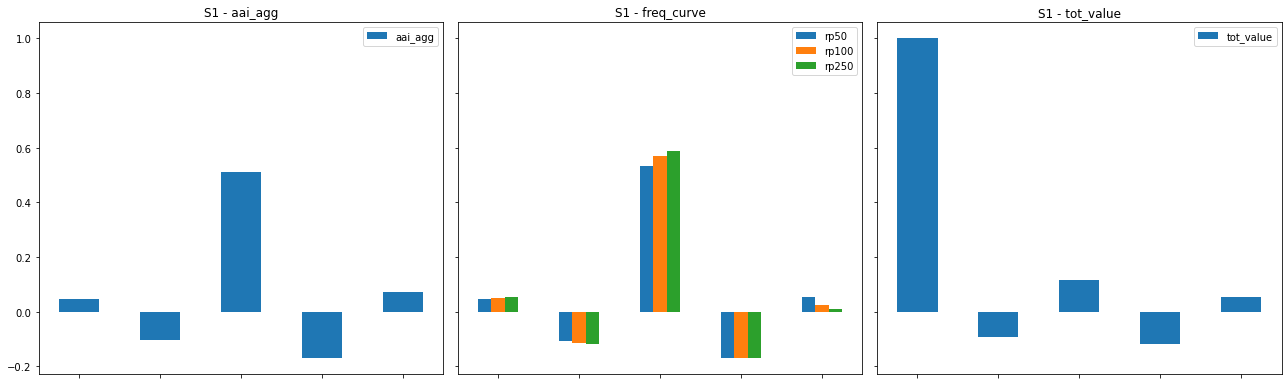

In [56]:
unc.plot_sensitivity();

## Cost Benefit uncertainty and sensitivity analysis

In [61]:
def ent_today(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    entity.check()
    return entity

def ent_future():
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040
    entity.check()
    return entity

def haz_fut_func(x_haz_fut, haz_base=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


In [62]:
haz = haz_base

haz_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_distr)

ent_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_unc = UncVar(ent_today, ent_distr)

ent_fut = ent_future()

2021-03-05 16:18:03,430 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,431 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,432 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,433 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,434 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-05 16:18:03,468 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,469 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,469 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,470 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,471 - climada.entity.exposures.base - INFO - crs set to default

In [63]:
unc = UncCostBenefit(haz_unc=haz, ent_unc=ent_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut)
unc.make_sample(N=10)
unc.sample.head()

2021-03-05 16:18:03,618 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 60


,x_ent,x_haz_fut
0,0.919727,1.290039
1,1.218555,1.290039
2,0.919727,3.030273
3,0.919727,3.030273
4,1.218555,1.290039


In [64]:
pool = Pool()
unc.calc_distribution(pool=pool)
pool.close()
pool.join()
pool.clear()

2021-03-05 16:18:03,631 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,632 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,633 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,634 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,635 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-05 16:18:03,666 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,667 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,667 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,668 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,669 - climada.entity.exposures.base - INFO - crs set to default

In [65]:
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

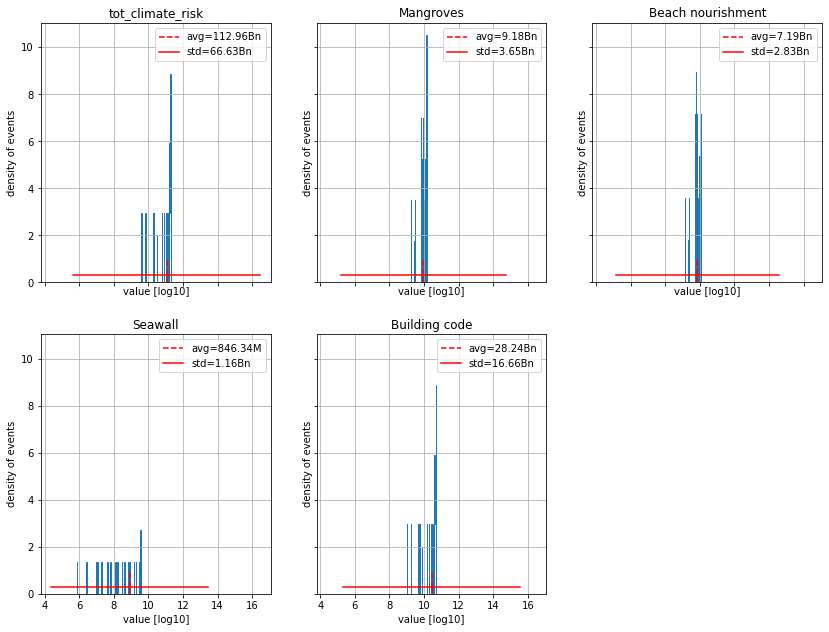

In [66]:
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

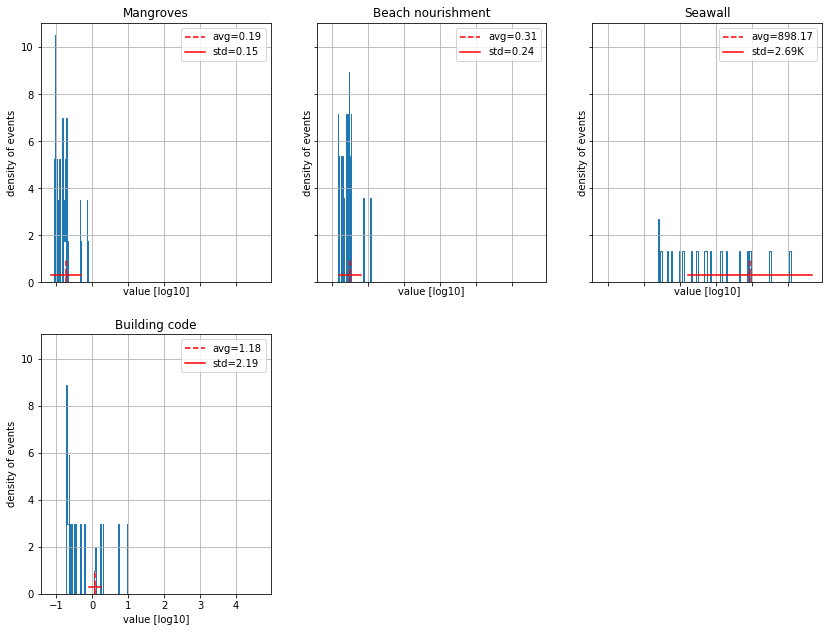

In [67]:
unc.plot_distribution(metric_list=['cost_ben_ratio'], );

In [68]:
unc.calc_sensitivity()

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

{'tot_climate_risk': {'tot_climate_risk': {'S1': array([0.0018922 , 0.80416505]),
   'S1_conf': array([0.00298371, 0.60869264]),
   'ST': array([9.70209053e-06, 8.34154299e-01]),
   'ST_conf': array([1.25990287e-05, 4.78951001e-01]),
   'S2': array([[        nan, -0.00376499],
          [        nan,         nan]]),
   'S2_conf': array([[      nan, 0.0059521],
          [      nan,       nan]])}},
 'benefit': {'Mangroves': {'S1': array([0.01246896, 1.33346589]),
   'S1_conf': array([0.02074035, 0.83737701]),
   'ST': array([7.98637483e-04, 1.15435338e+00]),
   'ST_conf': array([0.00100091, 0.34090604]),
   'S2': array([[        nan, -0.02334064],
          [        nan,         nan]]),
   'S2_conf': array([[       nan, 0.03978184],
          [       nan,        nan]])},
  'Beach nourishment': {'S1': array([0.01232256, 1.35383812]),
   'S1_conf': array([0.02622251, 0.92865791]),
   'ST': array([8.83987380e-04, 1.20059475e+00]),
   'ST_conf': array([0.0013722 , 0.38086757]),
   'S2': arr

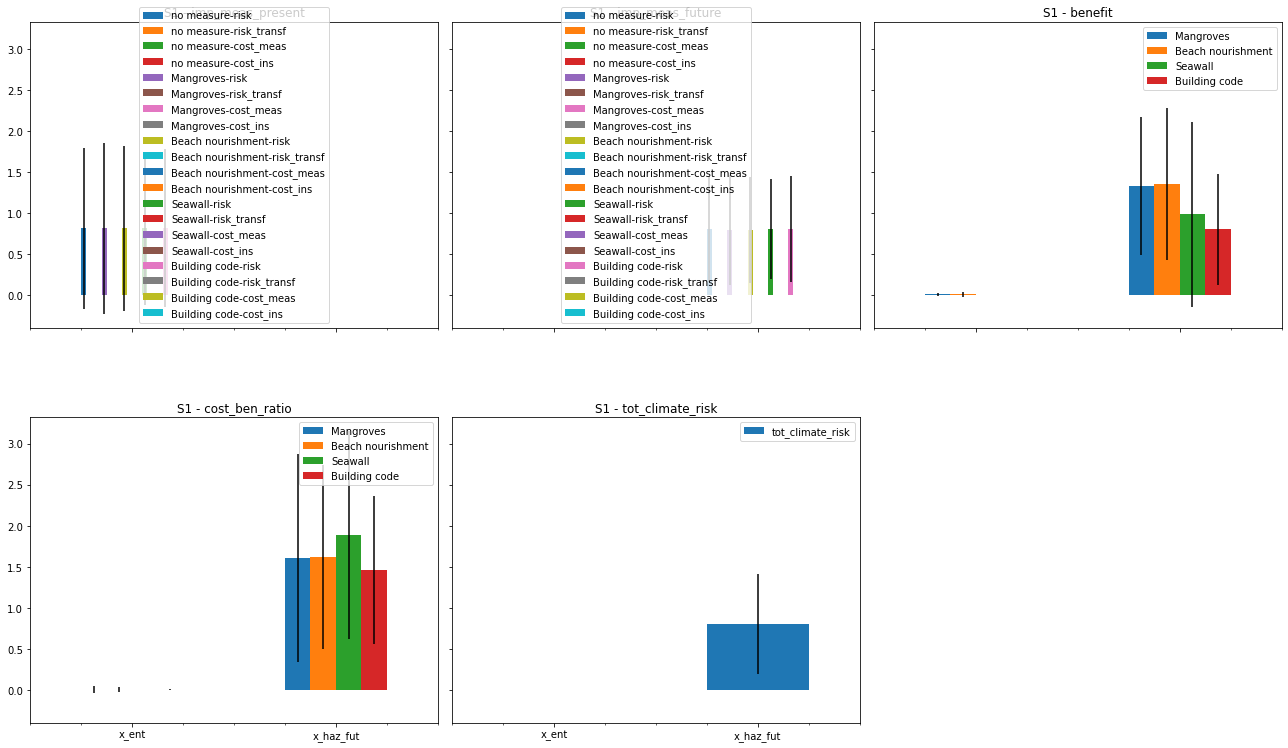

In [69]:
unc.plot_sensitivity();

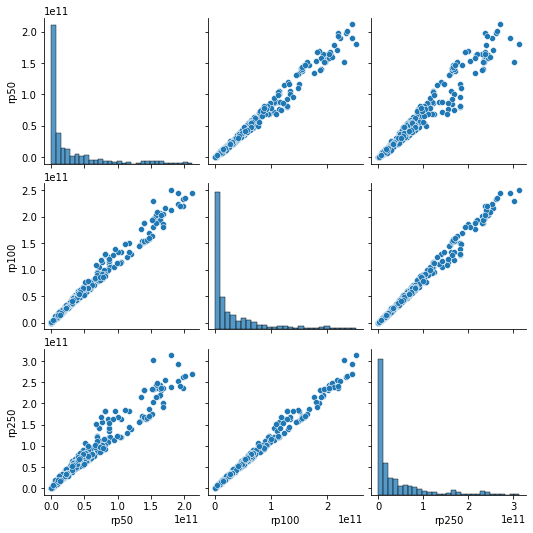

In [45]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);